In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import os
import sys
sys.path.insert(0,'/home/djl34/kl_git/scripts')
from notebook_imports import *

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import glob
import raklette
from run_raklette import TSVDataset, get_neutral_sfs

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.nn import PyroModule

from raklette import raklette_NN_1layer, raklette_NN_2layer_Config, raklette_NN_2layer
import plotly.express as px

from dataclasses import dataclass



# Running by leaving out site

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [54]:
neutral_sfs_filename = os.path.join(KL_data_dir, "whole_genome/freq_bins/freq_bin_9_all.tsv")

n_bins, neutral_sfs = get_neutral_sfs(neutral_sfs_filename, device = device)

cfg = raklette_NN_2layer_Config(neutral_sfs = neutral_sfs, 
                                n_covs = 2, 
                                n_hidden = 2,
                                n_bins = neutral_sfs.shape[1] - 1,
                                device = device)

number of bins: 8


In [55]:
num_epochs = 5
lr = 0.1
gamma = 0.5
mu_col = 0
bin_col = 1
cov_col = 2

In [56]:
header = "/n/scratch/users/d/djl34/kl_input/phylop/50bp_leave_out_phastcons_primates_"
chunksize = 1000000
# chrom = None
chrom = 22
dataset = TSVDataset(header = header, chunksize=chunksize, chrom = chrom, device = device)
loader = DataLoader(dataset, batch_size=1, num_workers=1, shuffle=True)

In [57]:
KL = raklette.raklette_NN_2layer(cfg)
# KL = raklette.raklette_neuralnet(neutral_sfs, n_bins, n_covs, device)

model = KL.model
guide = pyro.infer.autoguide.AutoNormal(model)

#run inference
pyro.clear_param_store()

num_steps = num_epochs * len(loader)
lrd = gamma ** (1 / num_steps)

# run SVI
optimizer = pyro.optim.ClippedAdam({"lr":lr, 'lrd': lrd})
#     optimizer = pyro.optim.Adam({"lr":lr})
elbo = pyro.infer.Trace_ELBO(num_particles=1, vectorize_particles=True)
svi = pyro.infer.SVI(model, guide, optimizer, elbo)

losses = []
divide_by = 1

In [58]:
print_loss = True
log_freq = 10

for epoch in range(num_epochs):
    progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for i, data in enumerate(progress_bar):            
        ## changing values into tensor format

        mu_vals = data[:,:,mu_col].reshape(-1)
        mu_vals = mu_vals.type(torch.LongTensor)
        

        freq_bins = data[:,:,bin_col].reshape(-1)

        if n_covs == 1:
            covariate_vals = torch.squeeze(data[:,:,cov_col:]).unsqueeze(-1)
        else:
            covariate_vals = torch.squeeze(data[:,:,cov_col:])
            
        covariate_vals = covariate_vals.type(torch.FloatTensor)

        loss = svi.step(mu_vals.to(device), covariate_vals.to(device), freq_bins.to(device))
        normalized_loss = loss/data.shape[1]

        # Update the progress bar with the current loss
        progress_bar.set_postfix({'loss': normalized_loss})

        losses.append(normalized_loss)
        

Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:20<00:00,  4.12it/s, loss=0.61]


In [ ]:
sfs_pred = model(mu_vals.to(device), covariate_vals.to(device)).detach()

df = pd.DataFrame(sfs_pred.cpu().squeeze().numpy())

df["mu_index"] = mu_vals.cpu().numpy()
df["phastcons"] = covariate_vals[:, 0]
df["sum_p"] = covariate_vals[:, 1]

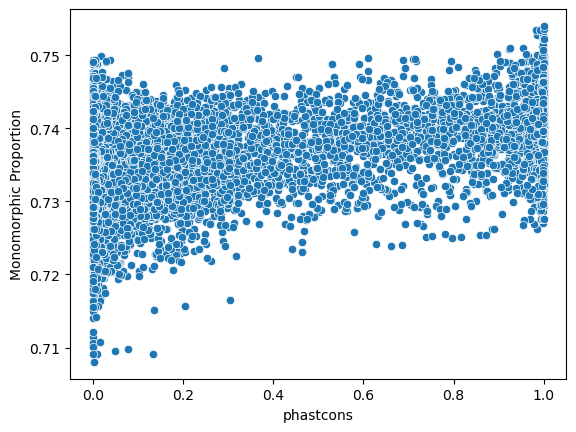

Text(0, 0.5, 'Monomorphic Proportion')

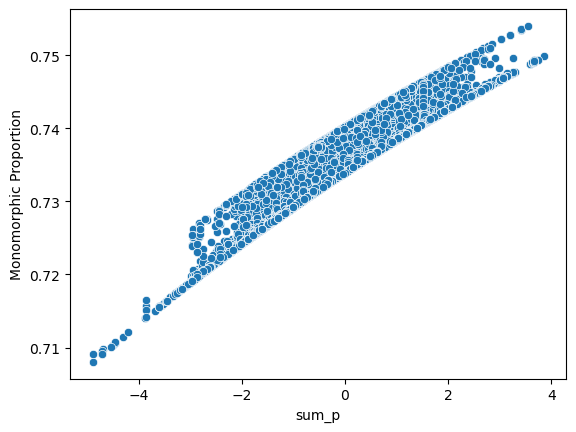

In [67]:
mu_index = 10
df_plot = df[df["mu_index"] == mu_index]

sns.scatterplot(data=df_plot, x="phastcons", y=0)
plt.ylabel('Monomorphic Proportion')
plt.show()

sns.scatterplot(data=df_plot, x="sum_p", y=0)
plt.ylabel('Monomorphic Proportion')

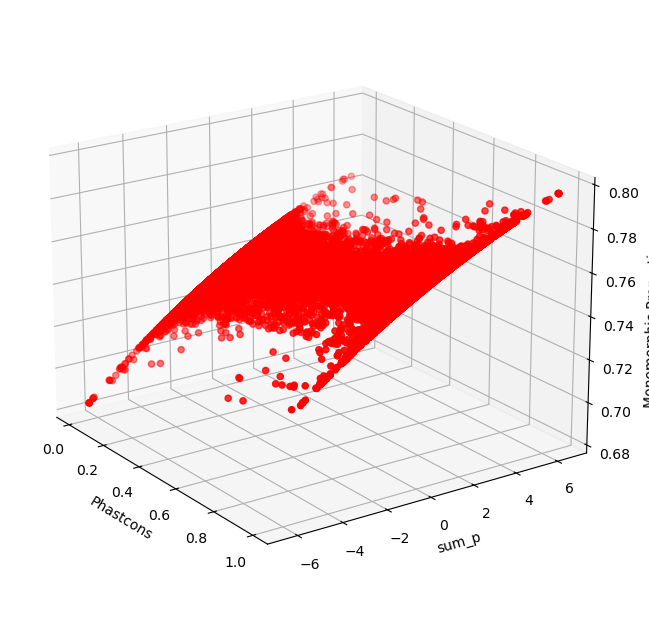

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20., azim=-35, roll=0)
# Plot the data
ax.scatter(df_plot['phastcons'], df_plot['sum_p'], df_plot[0], c='r', marker='o')

# Set labels
ax.set_xlabel('Phastcons')
ax.set_ylabel('sum_p')
ax.set_zlabel('Monomorphic Proportion')

plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0)
plt.show()


# Don't leave out site

In [68]:
header = "/n/scratch/users/d/djl34/kl_input/phylop/phastcons_primates_"
chunksize = 1000000
# chrom = None
chrom = 22
dataset = TSVDataset(header = header, chunksize=chunksize, chrom = chrom, device = device)
loader = DataLoader(dataset, batch_size=1, num_workers=1, shuffle=True)

In [69]:
KL = raklette.raklette_NN_2layer(cfg)
# KL = raklette.raklette_neuralnet(neutral_sfs, n_bins, n_covs, device)

model = KL.model
guide = pyro.infer.autoguide.AutoNormal(model)

#run inference
pyro.clear_param_store()

num_steps = num_epochs * len(loader)
lrd = gamma ** (1 / num_steps)

# run SVI
optimizer = pyro.optim.ClippedAdam({"lr":lr, 'lrd': lrd})
#     optimizer = pyro.optim.Adam({"lr":lr})
elbo = pyro.infer.Trace_ELBO(num_particles=1, vectorize_particles=True)
svi = pyro.infer.SVI(model, guide, optimizer, elbo)

losses = []
divide_by = 1

print_loss = True
log_freq = 10

for epoch in range(num_epochs):
    progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for i, data in enumerate(progress_bar):            
        ## changing values into tensor format

        mu_vals = data[:,:,mu_col].reshape(-1)
        mu_vals = mu_vals.type(torch.LongTensor)
        

        freq_bins = data[:,:,bin_col].reshape(-1)

        if n_covs == 1:
            covariate_vals = torch.squeeze(data[:,:,cov_col:]).unsqueeze(-1)
        else:
            covariate_vals = torch.squeeze(data[:,:,cov_col:])
            
        covariate_vals = covariate_vals.type(torch.FloatTensor)

        loss = svi.step(mu_vals.to(device), covariate_vals.to(device), freq_bins.to(device))
        normalized_loss = loss/data.shape[1]

        # Update the progress bar with the current loss
        progress_bar.set_postfix({'loss': normalized_loss})

        losses.append(normalized_loss)
        

Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:20<00:00,  4.11it/s, loss=0.62]


In [70]:
sfs_pred = model(mu_vals.to(device), covariate_vals.to(device)).detach()

df = pd.DataFrame(sfs_pred.cpu().squeeze().numpy())

df["mu_index"] = mu_vals.cpu().numpy()
df["phastcons"] = covariate_vals[:, 0]
df["sum_p"] = covariate_vals[:, 1]

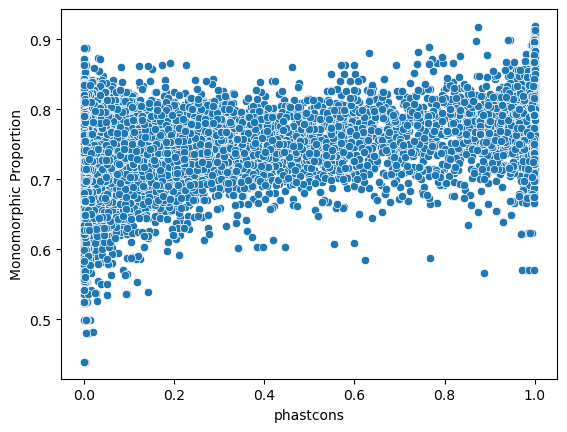

Text(0, 0.5, 'Monomorphic Proportion')

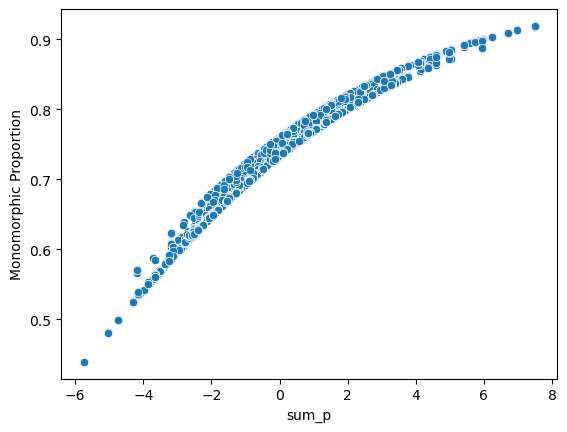

In [71]:
mu_index = 10
df_plot = df[df["mu_index"] == mu_index]

sns.scatterplot(data=df_plot, x="phastcons", y=0)
plt.ylabel('Monomorphic Proportion')
plt.show()

sns.scatterplot(data=df_plot, x="sum_p", y=0)
plt.ylabel('Monomorphic Proportion')